<a href="https://colab.research.google.com/github/pngy87/-PTDLNC-GOOGLE-COLAB/blob/main/%5BCHAPTER%208.2%5D%207_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. CLUSTERING


In [ ]:
#load data
import gdown
url = "https://drive.google.com/uc?id=1yzZ8swDKvzxmyqrCvPWwGe7kSavChVG3"
file_path = "Mall_Customers.csv"
gdown.download(url, file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yzZ8swDKvzxmyqrCvPWwGe7kSavChVG3
To: /content/Mall_Customers.csv
100%|██████████| 3.78k/3.78k [00:00<00:00, 8.27MB/s]


'Mall_Customers.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# =============== 1) LOAD DATA ===============

df = pd.read_csv("Mall_Customers.csv")

print("Kích thước dữ liệu:", df.shape)
print(df.head())

# Chuẩn hóa tên cột cho chắc (loại bỏ khoảng trắng, viết thường)
df.columns = [c.strip().lower() for c in df.columns]



Kích thước dữ liệu: (200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [ ]:
# =============== 2) CHỌN FEATURES ===============
# Các lựa chọn phổ biến:
#   (A) Dễ trực quan 2D: chỉ dùng Income + Spending Score
#   (B) Thêm Age, và mã hoá Gender -> phân cụm đa biến
USE_SIMPLE_2D = True

if USE_SIMPLE_2D:
    features = ["annual income (k$)", "spending score (1-100)"]  # 2D
else:
    # Chuẩn hoá giới tính: Female=1, Male=0 (tuỳ dataset)
    if 'gender' in df.columns:
        df['gender_num'] = (df['gender'].str.lower().str.strip() == 'female').astype(int)
    else:
        df['gender_num'] = np.nan  # nếu không có thì bỏ
    cand = ['gender_num', 'age', "annual income (k$)", "spending score (1-100)"]
    features = [c for c in cand if c in df.columns]

X = df[features].copy()

# Xử lý missing nếu có
X = X.dropna()
print("\nSử dụng các features:", features)
print("Số dòng sau khi dropna:", X.shape[0])




Sử dụng các features: ['annual income (k$)', 'spending score (1-100)']
Số dòng sau khi dropna: 200


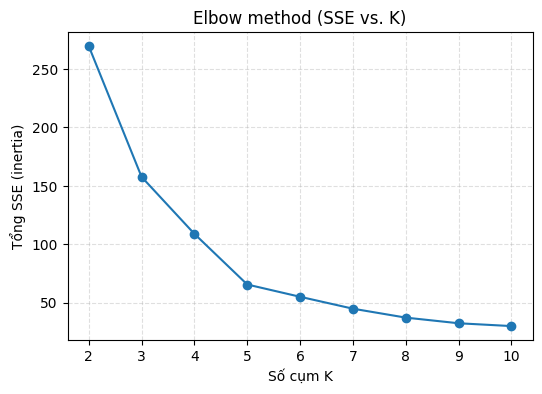

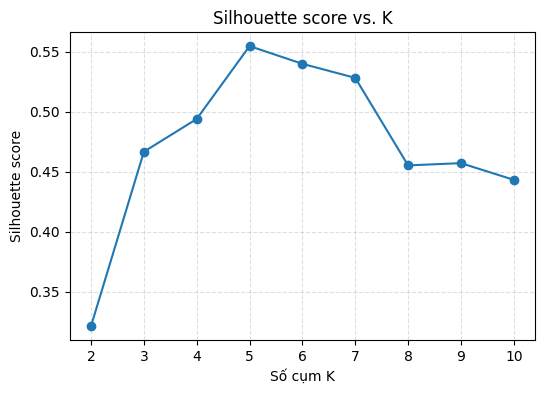


Gợi ý số cụm theo Silhouette: K = 5 (score = 0.555)


In [ ]:
# =============== 3) SCALING (tuỳ chọn) ===============
# K-Means nhạy scale. Với 2D (Income, Spending), không scale cũng dễ hiểu.
# Nếu bạn muốn công bằng đơn vị, hãy bật scale = True
scale_features = True

if scale_features:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X.values

# =============== 4) CHỌN SỐ CỤM (Elbow + Silhouette) ===============
inertias = []
sil_scores = []
K_range = range(2, 11)  # thử từ 2 -> 10 cụm

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)  # tổng SSE trong cụm
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Vẽ Elbow
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow method (SSE vs. K)")
plt.xlabel("Số cụm K")
plt.ylabel("Tổng SSE (inertia)")
plt.xticks(list(K_range))
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Vẽ Silhouette
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette score vs. K")
plt.xlabel("Số cụm K")
plt.ylabel("Silhouette score")
plt.xticks(list(K_range))
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Gợi ý K theo silhouette tối đa
best_k = K_range[int(np.argmax(sil_scores))]
print(f"\nGợi ý số cụm theo Silhouette: K = {best_k} (score = {max(sil_scores):.3f})")



In [ ]:
# =============== 5) HUẤN LUYỆN K-MEANS ===============
#K = best_k  # bạn có thể set thủ công, ví dụ K=5
K = 4
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_clusters = X.copy()
df_clusters['cluster'] = labels

# Tọa độ tâm cụm (trên không gian đã scale)
centers_scaled = kmeans.cluster_centers_

# Nếu muốn xem tâm cụm ở thang ban đầu:
if scale_features:
    centers_original = pd.DataFrame(
        scaler.inverse_transform(centers_scaled),
        columns=features
    )
else:
    centers_original = pd.DataFrame(centers_scaled, columns=features)

print("\nTâm cụm (thang đo gốc):")
print(centers_original.round(2))




Tâm cụm (thang đo gốc):
   annual income (k$)  spending score (1-100)
0               26.30                   20.91
1               87.00                   18.63
2               48.26                   56.48
3               86.54                   82.13


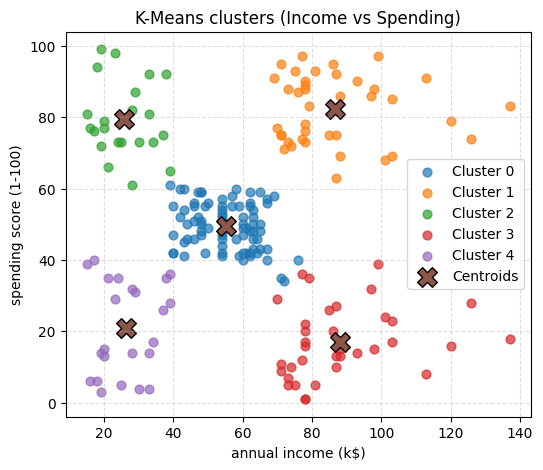

In [ ]:
# =============== 6) TRỰC QUAN HÓA ===============
# - Nếu dùng 2D (Income, Spending) => scatter trực tiếp
# - Nếu >2 biến => dùng PCA để giảm về 2D cho minh họa
if len(features) == 2:
    plt.figure(figsize=(6,5))
    for c in range(K):
        mask = labels == c
        plt.scatter(X.iloc[mask, 0], X.iloc[mask, 1], s=40, alpha=0.7, label=f"Cluster {c}")
    # tâm cụm (gốc)
    plt.scatter(centers_original[features[0]], centers_original[features[1]],
                marker='X', s=200, edgecolor='black', linewidths=1, label='Centroids')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title("K-Means clusters (Income vs Spending)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()
else:
    # PCA 2D
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    centers_pca = pca.transform(centers_scaled)

    plt.figure(figsize=(6,5))
    for c in range(K):
        mask = labels == c
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=40, alpha=0.7, label=f"Cluster {c}")
    plt.scatter(centers_pca[:,0], centers_pca[:,1],
                marker='X', s=200, edgecolor='black', linewidths=1, label='Centroids')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("K-Means clusters (PCA 2D)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()



In [ ]:
# =============== 7) TÓM TẮT THEO CỤM (DIỄN GIẢI) ===============
summary = df_clusters.groupby('cluster').agg(['mean','median','min','max','count'])
print("\nTóm tắt theo cụm (mean/median/min/max/count):")
print(summary)

# Gợi ý nhãn kinh doanh theo income/spending (nếu 2D)
if len(features) == 2 and set(features) == {"annual income (k$)", "spending score (1-100)"}:
    # Quy tắc đơn giản: dựa trên tâm cụm
    tmp = centers_original.copy()
    tmp['cluster'] = range(K)
    tmp = tmp.sort_values(by=["annual income (k$)", "spending score (1-100)"], ascending=[True, True]).reset_index(drop=True)

    print("\nGợi ý cách đặt tên cụm (cơ bản, dựa trên thu nhập & chi tiêu):")
    print("- Cụm thu nhập thấp – chi tiêu thấp")
    print("- Cụm thu nhập thấp – chi tiêu cao (tiềm năng upsell)")
    print("- Cụm thu nhập cao – chi tiêu thấp (cần kích hoạt mua sắm)")
    print("- Cụm thu nhập cao – chi tiêu cao (VIP)")
    print("\nBạn có thể map tên cụm thủ công sau khi xem centers_original.")



Tóm tắt theo cụm (mean/median/min/max/count):
        annual income (k$)                       spending score (1-100)  \
                      mean median min  max count                   mean   
cluster                                                                   
0                55.296296   54.0  39   76    81              49.518519   
1                86.538462   79.0  69  137    39              82.128205   
2                25.727273   24.5  15   39    22              79.363636   
3                88.200000   85.0  70  137    35              17.114286   
4                26.304348   25.0  15   39    23              20.913043   

                              
        median min max count  
cluster                       
0         50.0  34  61    81  
1         83.0  63  97    39  
2         77.0  61  99    22  
3         16.0   1  39    35  
4         17.0   3  40    23  

Gợi ý cách đặt tên cụm (cơ bản, dựa trên thu nhập & chi tiêu):
- Cụm thu nhập thấp – chi tiêu thấp
- Cụ

# Hierarchical (Agglomerative) Clustering Demo

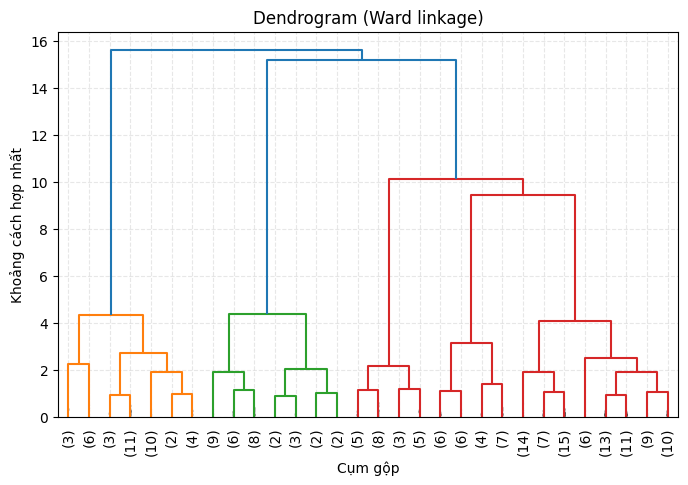

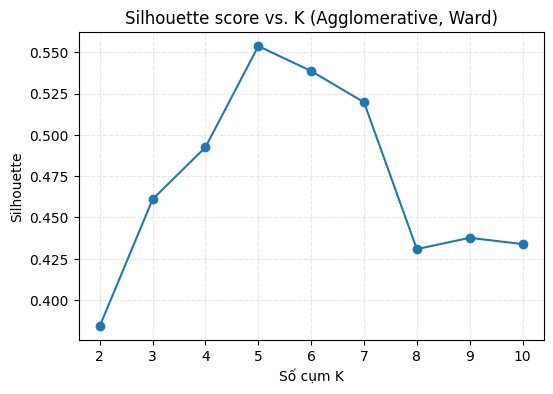

Gợi ý số cụm theo Silhouette: K = 5 (score = 0.554)


In [ ]:
# Mall Customers – Hierarchical (Agglomerative) Clustering Demo
# -------------------------------------------------------------
# File input: Mall_Customers.csv (CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# =============== 1) LOAD DATA ===============
FILE = "Mall_Customers.csv"
df = pd.read_csv(FILE)

# Chuẩn hóa tên cột
df.columns = [c.strip().lower() for c in df.columns]


# =============== 2) CHỌN FEATURES ===============
# Lựa chọn A (dễ trực quan): chỉ Income & Spending (2D)
# Lựa chọn B: thêm Age và Gender (phải mã hoá)
USE_SIMPLE_2D = True

if USE_SIMPLE_2D:
    features = ["annual income (k$)", "spending score (1-100)"]
else:
    if "gender" in df.columns:
        df["gender_num"] = (df["gender"].str.lower().str.strip() == "female").astype(int)
    cand = ["gender_num", "age", "annual income (k$)", "spending score (1-100)"]
    features = [c for c in cand if c in df.columns]

X = df[features].dropna().copy()

# =============== 3) SCALING ===============
# Hierarchical + khoảng cách Euclidean nên scale để công bằng thang đo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =============== 4) DENDROGRAM (dùng scipy) ===============
# Với Ward -> metric mặc định là Euclidean
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(8, 5))
dendrogram(
    Z,
    truncate_mode="lastp",  # gom nhánh để nhìn gọn (có thể bỏ nếu muốn full)
    p=30,                   # hiển thị 20 cụm lá cuối
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.title("Dendrogram (Ward linkage)")
plt.xlabel("Cụm gộp")
plt.ylabel("Khoảng cách hợp nhất")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Nếu muốn cắt theo ngưỡng khoảng cách (ví dụ t=8.0), dùng:
# clusters_by_dist = fcluster(Z, t=8.0, criterion='distance')

# =============== 5) CHỌN SỐ CỤM BẰNG SILHOUETTE ===============
K_range = range(2, 11)
sil_scores = []

for k in K_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_k = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker="o")
plt.title("Silhouette score vs. K (Agglomerative, Ward)")
plt.xlabel("Số cụm K")
plt.ylabel("Silhouette")
plt.xticks(list(K_range))
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

best_k = K_range[int(np.argmax(sil_scores))]
print(f"Gợi ý số cụm theo Silhouette: K = {best_k} (score = {max(sil_scores):.3f})")



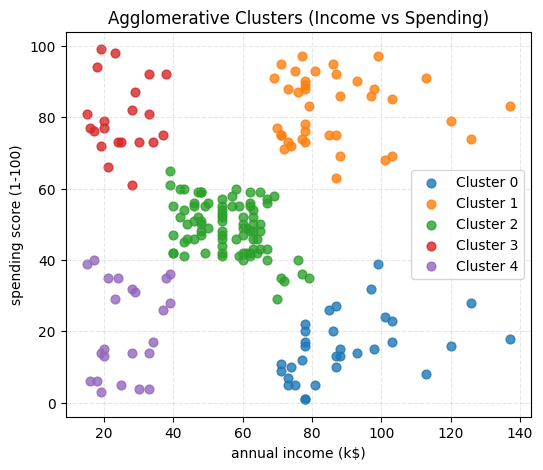


Tóm tắt theo cụm:
        annual income (k$)                       spending score (1-100)  \
                      mean median min  max count                   mean   
cluster                                                                   
0                89.406250   86.5  71  137    32              15.593750   
1                86.538462   79.0  69  137    39              82.128205   
2                55.811765   57.0  39   79    85              49.129412   
3                25.095238   24.0  15   38    21              80.047619   
4                26.304348   25.0  15   39    23              20.913043   

                              
        median min max count  
cluster                       
0         15.0   1  39    32  
1         83.0  63  97    39  
2         49.0  29  65    85  
3         77.0  61  99    21  
4         17.0   3  40    23  

Gợi ý đặt tên cụm theo Income & Spending (tham khảo):
- Thu nhập thấp – Chi tiêu thấp
- Thu nhập thấp – Chi tiêu cao (tiềm năng ups

In [ ]:
# =============== 6) HUẤN LUYỆN MÔ HÌNH VỚI K TỐI ƯU ===============
K = best_k
agg = AgglomerativeClustering(n_clusters=K, linkage="ward")
labels = agg.fit_predict(X_scaled)

df_clu = X.copy()
df_clu["cluster"] = labels

# =============== 7) TRỰC QUAN HÓA ===============
if len(features) == 2:
    # Vẽ trực tiếp trên 2 biến Income & Spending
    plt.figure(figsize=(6,5))
    for c in range(K):
        mask = labels == c
        plt.scatter(X.iloc[mask, 0], X.iloc[mask, 1], s=40, alpha=0.8, label=f"Cluster {c}")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title("Agglomerative Clusters (Income vs Spending)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()
else:
    # PCA về 2D để vẽ
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(6,5))
    for c in range(K):
        mask = labels == c
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=40, alpha=0.8, label=f"Cluster {c}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Agglomerative Clusters (PCA 2D)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

# =============== 8) TÓM TẮT CỤM (DIỄN GIẢI) ===============
summary = df_clu.groupby("cluster").agg(["mean","median","min","max","count"])
print("\nTóm tắt theo cụm:")
print(summary)

# Diễn giải nhanh (nếu dùng Income & Spending):
if set(features) == {"annual income (k$)", "spending score (1-100)"}:
    print("\nGợi ý đặt tên cụm theo Income & Spending (tham khảo):")
    print("- Thu nhập thấp – Chi tiêu thấp")
    print("- Thu nhập thấp – Chi tiêu cao (tiềm năng upsell)")
    print("- Thu nhập cao – Chi tiêu thấp (cần kích hoạt mua sắm)")
    print("- Thu nhập cao – Chi tiêu cao (VIP)")